In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm
import statsmodels.api as sm

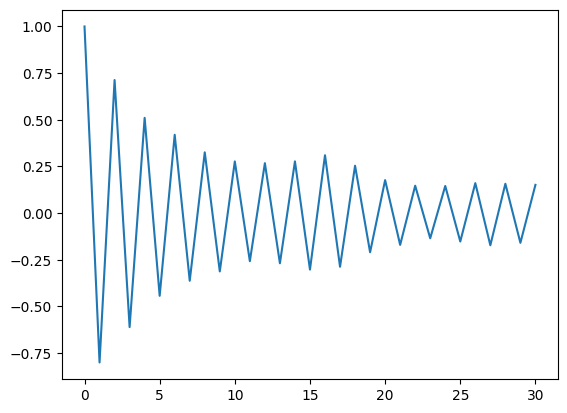

In [2]:
np.random.seed(42)

def AR2(phi_1, phi_2, n=200):
    e = np.random.randn(n)
    X = [e[0], e[1]]

    for t in range(2, n):
        X_t = e[t]-phi_1*X[t-1]-phi_2*X[t-2]
        X.append(X_t)

    return np.array(X)


res = AR2(0.6, -0.3)

emp_acf = acf(res, nlags=30, fft=True)

plt.plot(emp_acf)
plt.show()

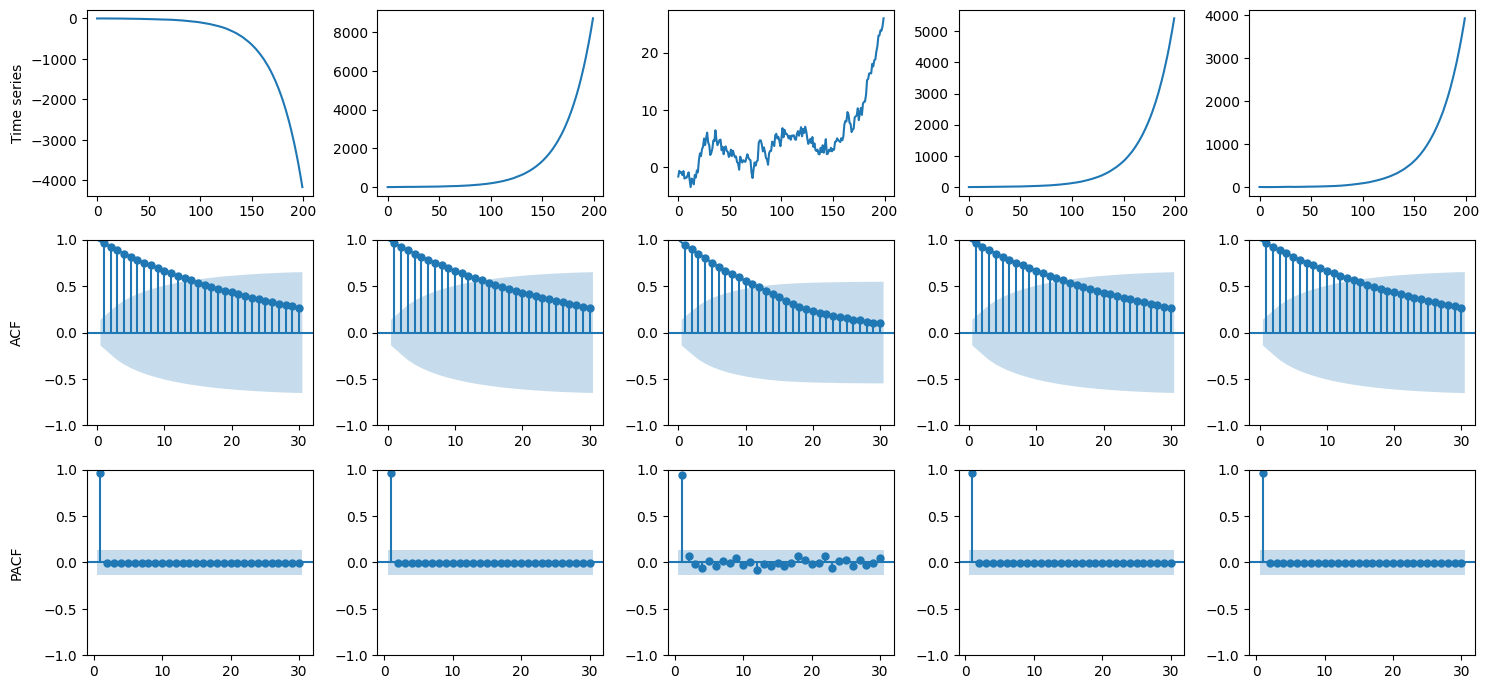

In [3]:
np.random.seed(42)

res = [AR2(-0.75, -0.3) for i in range(5)]

emp_acf = [acf(response, nlags=30, fft=True) for response in res]

fig, ax = plt.subplots(3, 5, figsize=(15, 7))

# Add row titles
# ax[0, 0].set_ylabel("Time series", labelpad=14)
ax[0, 0].set_ylabel("Time series")
ax[1, 0].set_ylabel("ACF", labelpad=14)
ax[2, 0].set_ylabel("PACF", labelpad=14)

for i, value in enumerate(res):
    ax[0, i].plot(value)
    ax[1, i].plot(emp_acf[i])
    # ax[1, i].axhline(0)
    plot_acf(res[i], lags=30, ax=ax[1, i], alpha=0.05, zero=False, color="tab:blue", title="")
    plot_pacf(res[i], lags=30, ax=ax[2, i], alpha=0.05, zero=False, color="tab:blue", title="")

plt.tight_layout()
plt.show()

# Part 2

In [4]:
import pandas as pd

In [5]:
df_solar = pd.read_csv("datasolar.csv")
np.random.seed(42)

In [6]:
Y = df_solar["power"].values

tsf = lambda a : np.log(a) - 5.72
invtsf = lambda a : np.exp(a + 5.72)


In [7]:
np.random.seed(42)
def AR_plant_onestep(Y_t, phi=-0.38, Phi=-0.94, sigma=0.22, n = 36):
    eps = np.random.randn(n) * sigma

    X = list(Y_t)
    pred_onestep= list(Y_t[:13])

    for t in range(13, n):
        X_t = -phi*X[t-1]-Phi*X[t-12]-phi*Phi*X[t-13]
        pred_onestep.append(X_t)
    
    return np.array(pred_onestep)

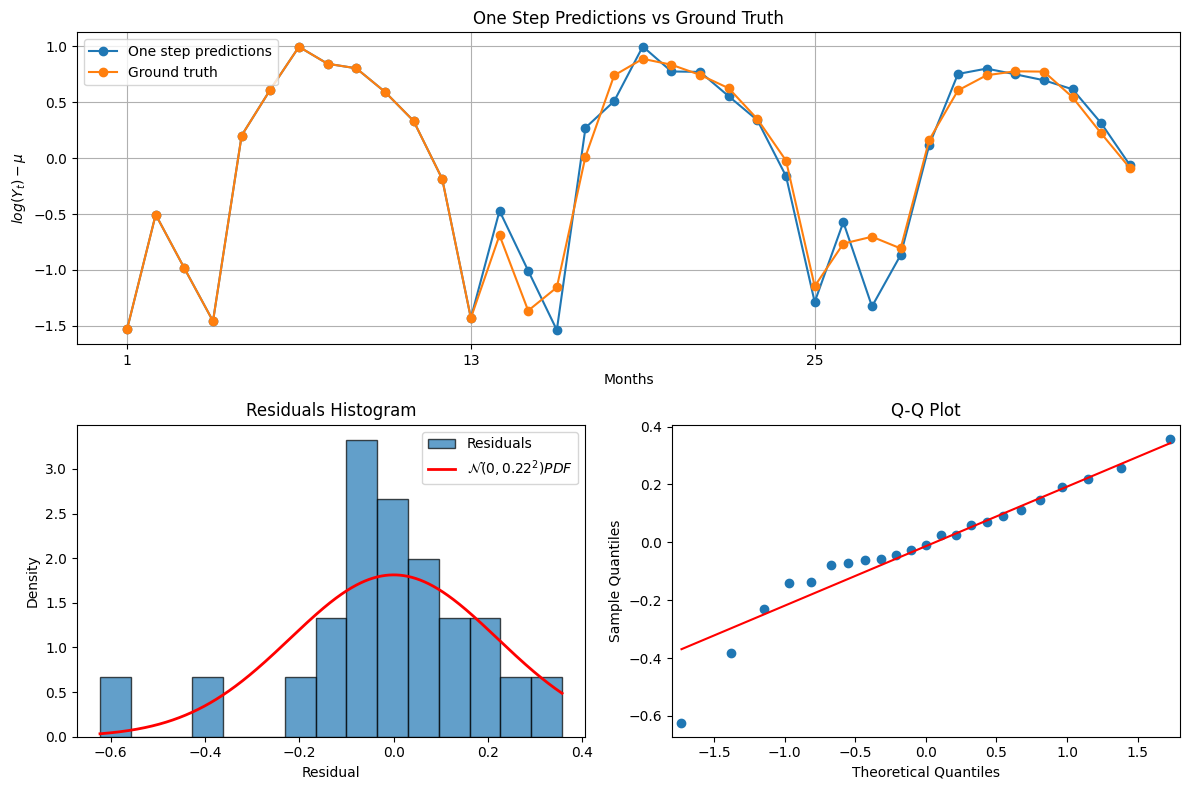

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import statsmodels.api as sm

# Assume: tsf(Y) is log(Y) - mu
Y_tsf = tsf(Y)
preds = AR_plant_onestep(Y_tsf)
res = preds - Y_tsf
res = res[13:]

fig = plt.figure(figsize=(12, 8))

# Top: Prediction vs Ground Truth (spans two columns)
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1.plot(np.arange(1, len(Y_tsf)+1), preds, marker='o', label='One step predictions')
ax1.plot(np.arange(1, len(Y_tsf)+1), Y_tsf, marker='o', label='Ground truth')
plt.xticks(np.arange(1, 36, 12))
plt.xlabel("Months")
plt.ylabel("$log(Y_t) - \mu$")
ax1.grid()
ax1.legend(loc='upper left')
ax1.set_title("One Step Predictions vs Ground Truth")

# Bottom left: Histogram with bell curve
ax2 = plt.subplot2grid((2, 2), (1, 0))
count, bins, ignored = ax2.hist(res, density=True, bins=15, alpha=0.7, edgecolor='black', label="Residuals")
x = np.linspace(min(bins), max(bins), 1000)
pdf = norm.pdf(x, 0, 0.22)
ax2.plot(x, pdf, 'r-', lw=2, label='$\mathcal{N}(0, 0.22^2) PDF$')
ax2.legend()
plt.xlabel("Residual")
plt.ylabel("Density")
ax2.set_title("Residuals Histogram")

# Bottom right: Q-Q plot
ax3 = plt.subplot2grid((2, 2), (1, 1))
sm.qqplot(res, line='s', ax=ax3)
ax3.set_title("Q-Q Plot")

plt.tight_layout()
plt.show()


**2.2**

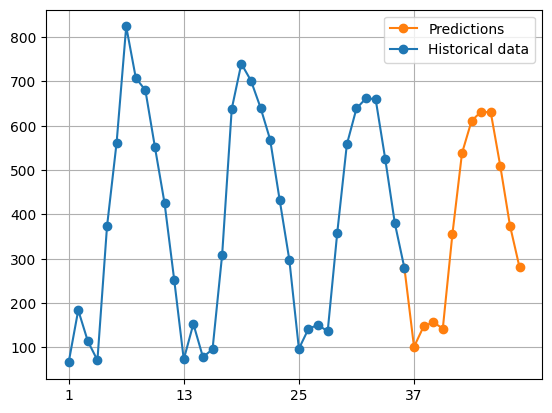

In [9]:
def AR_plant(Y_t, phi=-0.38, Phi=-0.94, sigma=0.22, n=None):

    if n is None:
        n = len(Y_t) + 12  # Forecast 12 months ahead
        
    X = list(Y_t)

    for t in range(len(Y_t), n):
        X_t = -phi*X[t-1]-Phi*X[t-12]-phi*Phi*X[t-13]
        X.append(X_t)
    
    return np.array(X)

plt.plot(np.arange(len(Y), len(Y)+13), invtsf(AR_plant(tsf(Y)))[-13:], marker='o', label="Predictions", color="tab:orange")
plt.plot(np.arange(len(Y))+1, Y, label="Historical data", marker = 'o', color="tab:blue")
plt.xticks(np.arange(1, 48, 12))
plt.grid()
plt.legend()
plt.show()

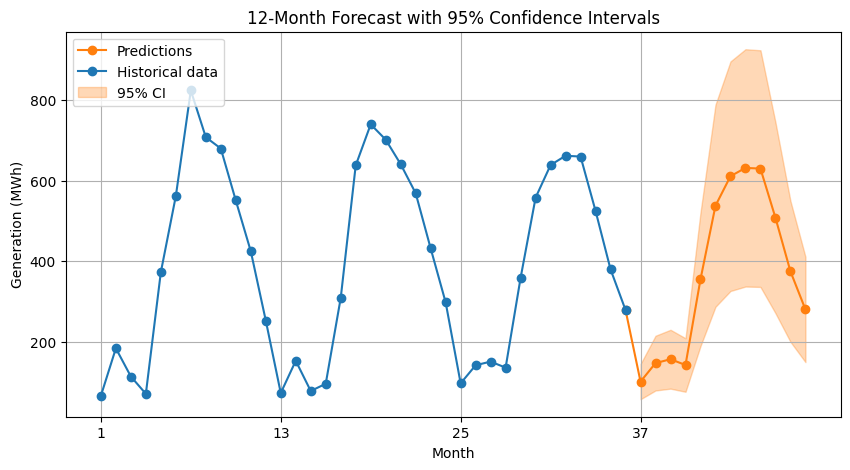

In [10]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

def psi_weights_ar(ar_coeffs, k_max):
    """
    Compute psi-weights for AR model up to k_max steps ahead.
    For ARMA models, use arma2psd or similar tools from statsmodels.
    """
    psi = [1.0]  # ψ₀ = 1
    for k in range(1, k_max):
        next_psi = -sum(ar_coeffs[i] * psi[k - i - 1] for i in range(min(len(ar_coeffs), k)))
        psi.append(next_psi)
    return np.array(psi)

# --- Forecasting ---
phi = -0.38
Phi = -0.94
mu = 5.72
sigma_eps = 0.22

X_full = AR_plant(tsf(Y), phi=phi, Phi=Phi)
X_pred = X_full[-12:]
X_pred_Y = np.exp(X_pred + mu)  # back-transform to original units

# --- Confidence intervals ---
k_steps = 12
ar_coeffs = [phi] + [0]*10 + [Phi] + [phi*Phi]  # include seasonal structure
psi = psi_weights_ar(ar_coeffs, k_steps)

# Prediction error std dev
sigma_k = sigma_eps * np.sqrt(np.cumsum(psi[:k_steps]**2))

# z for 95% CI
z = norm.ppf(0.975)

# Compute CI bounds
lower = X_pred_Y - z * sigma_k * X_pred_Y  # approximate via delta method
upper = X_pred_Y + z * sigma_k * X_pred_Y

# --- Plot ---
months = np.arange(len(Y), len(Y)+12)

plt.figure(figsize=(10, 5))

plt.plot(np.arange(len(Y), len(Y)+13), invtsf(AR_plant(tsf(Y)))[-13:], marker='o', label="Predictions", color="tab:orange")
plt.plot(np.arange(len(Y))+1, Y, label="Historical data", marker = 'o', color="tab:blue")
plt.xticks(np.arange(1, 48, 12))
plt.fill_between(months+1, lower, upper, color='tab:orange', alpha=0.3, label="95% CI")
plt.xlabel("Month")
plt.ylabel("Generation (MWh)")
plt.title("12-Month Forecast with 95% Confidence Intervals")
plt.grid()
plt.legend(loc=2)
plt.show()


# Part 3

In [11]:
df_box = pd.read_csv("box_data_60min.csv")
df_box

,thour,tdate,Ph,Tdelta,Gv,Ph.l0,Ph.l1,Ph.l2,Ph.l3,Ph.l4,...,Gv.l1,Gv.l2,Gv.l3,Gv.l4,Gv.l5,Gv.l6,Gv.l7,Gv.l8,Gv.l9,Gv.l10
0,19,2013-01-30 02:00:00,56,13.253583,-0.498643,56,55,57,57,58,...,-0.499338,-0.417959,-0.221011,-0.453375,-0.747238,-0.669267,-0.451776,-0.142700,8.262339,20.475484
1,20,2013-01-30 03:00:00,54,13.181458,-1.127035,54,56,55,57,57,...,-0.498643,-0.499338,-0.417959,-0.221011,-0.453375,-0.747238,-0.669267,-0.451776,-0.142700,8.262339
2,21,2013-01-30 04:00:00,55,12.968792,-0.643298,55,54,56,55,57,...,-1.127035,-0.498643,-0.499338,-0.417959,-0.221011,-0.453375,-0.747238,-0.669267,-0.451776,-0.142700
3,22,2013-01-30 05:00:00,54,12.667750,-0.456008,54,55,54,56,55,...,-0.643298,-1.127035,-0.498643,-0.499338,-0.417959,-0.221011,-0.453375,-0.747238,-0.669267,-0.451776
4,23,2013-01-30 06:00:00,54,12.605250,-1.534060,54,54,55,54,56,...,-0.456008,-0.643298,-1.127035,-0.498643,-0.499338,-0.417959,-0.221011,-0.453375,-0.747238,-0.669267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,245,2013-02-08 12:00:00,76,23.684292,264.619541,76,90,94,97,97,...,63.320010,39.317716,10.410304,0.189180,-0.065229,-0.205313,-0.687645,-1.081767,-0.497384,-0.136499
227,246,2013-02-08 13:00:00,58,23.389083,217.417135,58,76,90,94,97,...,264.619541,63.320010,39.317716,10.410304,0.189180,-0.065229,-0.205313,-0.687645,-1.081767,-0.497384
228,247,2013-02-08 14:00:00,63,23.231583,248.983866,63,58,76,90,94,...,217.417135,264.619541,63.320010,39.317716,10.410304,0.189180,-0.065229,-0.205313,-0.687645,-1.081767
229,248,2013-02-08 15:00:00,21,22.566833,638.279086,21,63,58,76,90,...,248.983866,217.417135,264.619541,63.320010,39.317716,10.410304,0.189180,-0.065229,-0.205313,-0.687645


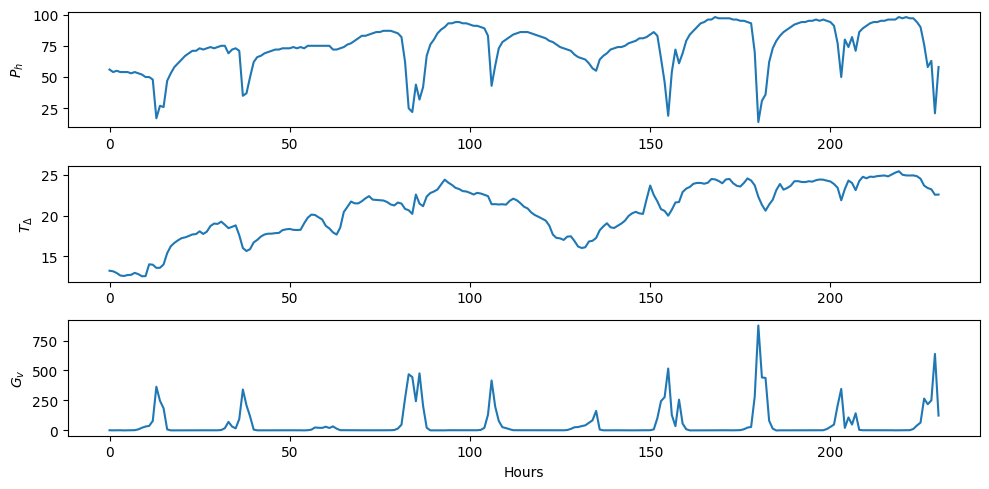

In [12]:
import matplotlib.pyplot as plt

# Line plots
fig, ax = plt.subplots(3, 1, figsize=(10, 5))
ax[0].plot(df_box['Ph'])
ax[0].set_ylabel('$P_h$')

ax[1].plot(df_box['Tdelta'])
ax[1].set_ylabel('$T_\Delta$')

ax[2].plot(df_box['Gv'])
ax[2].set_ylabel('$G_v$')


plt.xlabel("Hours")
plt.tight_layout()
plt.show()


c:\Users\LEMC0001\Documents\uni\Timeseries\venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\LEMC0001\AppData\Local\Temp\ipykernel_25592\4041358490.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['log ($G_v$)'] = np.log(df_train['Gv'])
C:\Users\LEMC0001\AppData\Local\Temp\ipykernel_25592\4041358490.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['$P_h$'] = df_train['Ph'

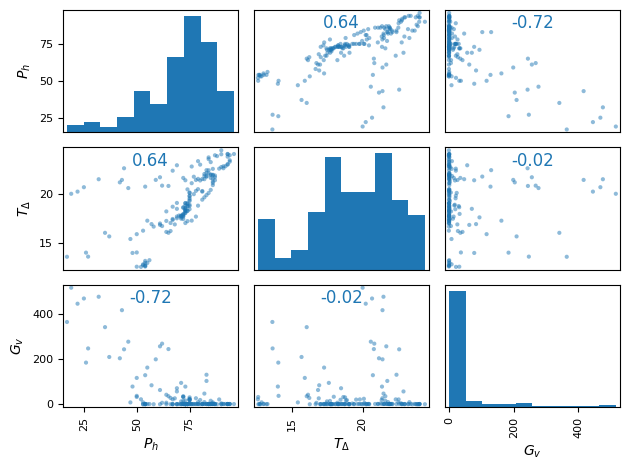

In [34]:
df_train = df_box.iloc[:167] # The dataset doesnt have timestamps for the first 18 hours? lol. This matches with the definition given for the timestamp, but t_hour is 19,...,185, not 1,...,167


df_train['log ($G_v$)'] = np.log(df_train['Gv'])

df_train['$P_h$'] = df_train['Ph'].values
df_train['$T_\Delta$'] = df_train['Tdelta'].values
df_train['$G_v$'] = df_train['Gv'].values

df_selected = df_train[['$P_h$',
                        '$T_\Delta$',
                        '$G_v$']]

axes = pd.plotting.scatter_matrix(df_selected)

cols = df_selected.columns
n = len(cols)

# Loop through upper triangle to add correlation coefficients
for i in range(n):
    for j in range(n):
        # if i < j:
        if i is not j:
            corr = np.corrcoef(df_selected[cols[j]], df_selected[cols[i]])[0, 1]
            ax = axes[i, j]
            ax.annotate(f"{corr:.2f}", xy=(0.5, 0.85), xycoords='axes fraction',
                        ha='center', fontsize=12, color='tab:blue')


plt.tight_layout()
plt.show()

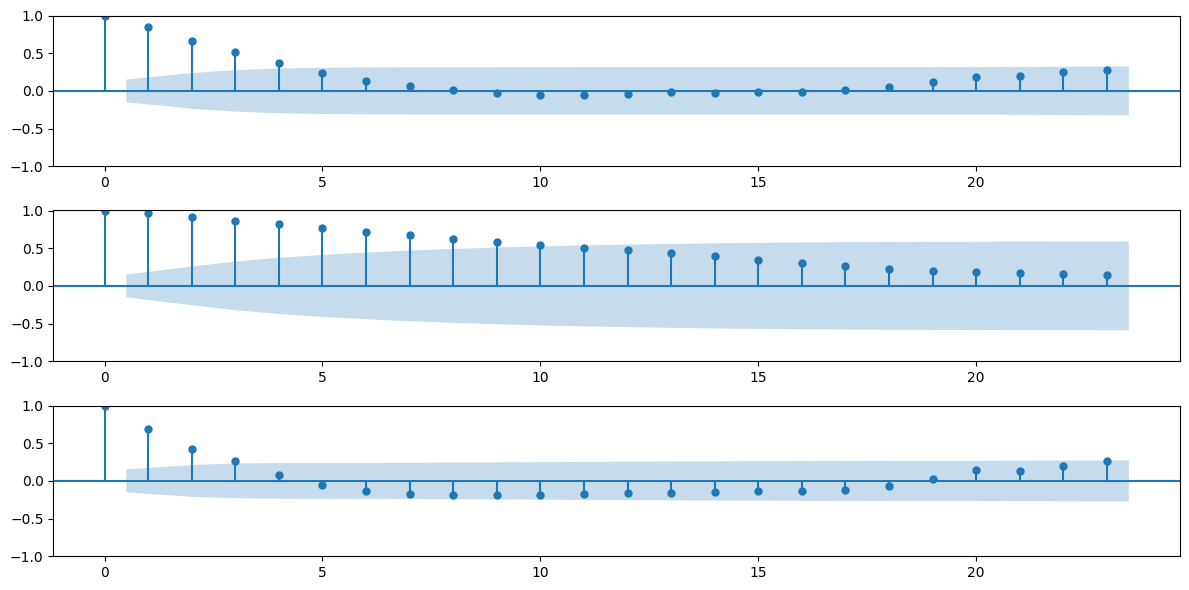

In [59]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

variables = ['$P_h$', '$T_\Delta$', '$G_v$']

fig, axes = plt.subplots(len(variables), 1, figsize=(12, 6))

for i, var in enumerate(variables):
    plot_acf(df_train[var], ax=axes[i], title="")
    # plt.ylabel("autocorrelation")

plt.tight_layout()
plt.show()
